<a href="https://colab.research.google.com/github/Vitz2007/ev_car_analysis/blob/main/EV_Car_Analysis_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Mount GDrive to access file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
#Import csv file
ev_df = pd.read_csv('/content/drive/MyDrive/EV car registers/ca_ev_registrations_public.csv', low_memory=False)
print(ev_df.head(20))

        Vehicle ID County GEOID  ... Geography    Vehicle Name
0   CA-002-03597\r        06099  ...    County  Chevrolet Volt
1   CA-002-03598\r        06105  ...    County     Nissan Leaf
2   CA-002-03599\r        06103  ...    County  Chevrolet Volt
3   CA-002-03600\r        06099  ...    County  Tesla Roadster
4   CA-002-03601\r        06099  ...    County  Tesla Roadster
5   CA-002-03602\r        06097  ...    County  Tesla Roadster
6   CA-002-03603\r        06097  ...    County  Tesla Roadster
7   CA-002-03604\r        06097  ...    County  Tesla Roadster
8   CA-002-03605\r        06097  ...    County  Tesla Roadster
9   CA-002-03606\r        06097  ...    County  Tesla Roadster
10  CA-002-03607\r        06097  ...    County  Tesla Roadster
11  CA-002-03608\r        06097  ...    County     Nissan Leaf
12  CA-002-03609\r        06097  ...    County     Nissan Leaf
13  CA-002-03610\r        06097  ...    County     Nissan Leaf
14  CA-002-03611\r        06097  ...    County     Niss

In [5]:
#Get overview of data
print(ev_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542443 entries, 0 to 2542442
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Vehicle ID                    object 
 1   County GEOID                  object 
 2   Registration Valid Date       object 
 3   DMV ID                        int64  
 4   DMV Snapshot                  object 
 5   Registration Expiration Date  float64
 6   State Abbreviation            object 
 7   Geography                     object 
 8   Vehicle Name                  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 174.6+ MB
None


In [6]:
#Drop unnecessary columns
ev_df.drop(['DMV ID', 'DMV Snapshot', 'Registration Expiration Date', 'Geography'], axis=1, inplace=True)

In [7]:
#Find any NaNs
ev_df_nulls = ev_df.isnull().sum()
print(ev_df_nulls)

Vehicle ID                 0
County GEOID               0
Registration Valid Date    0
State Abbreviation         0
Vehicle Name               0
dtype: int64


In [8]:
#Get min, max, mean, etc
print(ev_df_nulls.describe())

count    5.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
dtype: float64


In [9]:
#Determine count of each EV car in 'Vehicle Name'
ev_df_car_count = ev_df['Vehicle Name'].value_counts()
print(ev_df_car_count.head(15))

Chevrolet Volt           349602
Tesla Model 3            306928
Tesla Model S            301845
Nissan Leaf              231254
Toyota Prius Plug-in     187338
Ford Fusion Energi       136075
Toyota Prius Prime       109236
Tesla Model X             99285
Chevrolet Bolt EV         95896
Fiat 500e                 87449
Ford C-Max Energi         84600
BMW i3 REx                61679
Volkswagen e-Golf         45446
Honda Clarity Plug In     42504
BMW 5-Series Plug in      29485
Name: Vehicle Name, dtype: int64


In [10]:
#Extract year from 'Registration Valid Date' column
ev_df['year'] = pd.DatetimeIndex(ev_df['Registration Valid Date']).year
print(ev_df['year'])

0          2011
1          2011
2          2011
3          2011
4          2011
           ... 
2542438    2020
2542439    2020
2542440    2020
2542441    2020
2542442    2020
Name: year, Length: 2542443, dtype: int64


In [11]:
#Get frequecy of each car by year
ev_df = ev_df.groupby(['Vehicle Name', 'year']).year.size().reset_index(name='count')
print(ev_df)

           Vehicle Name  year  count
0       Audi A3 Plug In  2020   5315
1       Audi A7 Plug In  2020      2
2       Audi A8 Plug In  2020     21
3       Audi Q5 Plug In  2020   1629
4           Audi e-tron  2019   1449
..                  ...   ...    ...
411  Volvo XC90 Plug In  2016    421
412  Volvo XC90 Plug In  2017   1417
413  Volvo XC90 Plug In  2018   1844
414  Volvo XC90 Plug In  2019   2224
415  Volvo XC90 Plug In  2020   3334

[416 rows x 3 columns]


In [12]:
#Sort by descending 'year'
ev_df_sort = ev_df.sort_values(['year'], ascending=True)
print(ev_df_sort)

                         Vehicle Name  year  count
357                    Tesla Roadster  2010    431
136                       Ford Ranger  2010     51
259            Mini Hardtop 2 Door EV  2010    119
368              Toyota Prius Plug-in  2010    153
326                   Smart forTwo EV  2011     43
..                                ...   ...    ...
198                     Jaguar I-Pace  2020   1421
195            Hyundai Sonata Plug In  2020   2005
190             Hyundai Kona Electric  2020   3121
248  Mercedes GLE 550e Plug In Hybrid  2020    505
415                Volvo XC90 Plug In  2020   3334

[416 rows x 3 columns]


In [13]:
#Select top 10 ev cars with highest count
ev_hi_reg = ev_df_sort.loc[ev_df_sort['Vehicle Name'].isin(['Chevrolet Volt', 'Tesla Model 3', 'Tesla Model S', 'Nissan Leaf', 'Toyota Prius Plug-in', 
                                      'Ford Fusion Energi', 'Toyota Prius Prime', 'Tesla Model X', 'Chevrolet Bolt EV', 'Fiat 500e'])]
#print(ev_hi_reg)
print(ev_hi_reg)

             Vehicle Name  year   count
368  Toyota Prius Plug-in  2010     153
282           Nissan Leaf  2011    3638
369  Toyota Prius Plug-in  2011     162
79         Chevrolet Volt  2011    1320
342         Tesla Model S  2012      98
..                    ...   ...     ...
101             Fiat 500e  2020    8017
88         Chevrolet Volt  2020   53743
70      Chevrolet Bolt EV  2020   30601
291           Nissan Leaf  2020   30113
341         Tesla Model 3  2020  144311

[73 rows x 3 columns]


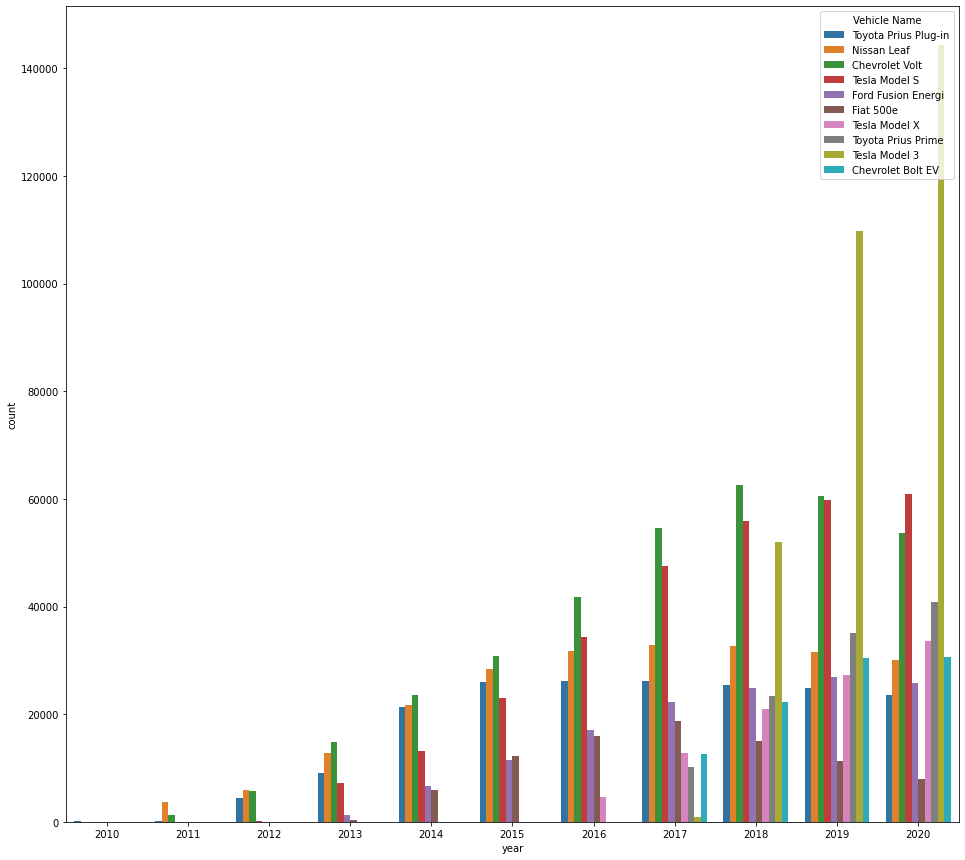

In [29]:
#Plot bar graph with count plot
bar_dim = (16, 15)
fig, ax = plt.subplots(figsize=bar_dim)
ev_plot = sns.barplot(x='year', y='count', hue='Vehicle Name', data=ev_hi_reg)
plt.show()

In [15]:
#We can see Toyota Prius Plug-in & Nissan were tied and remained unchanged afterwards and US manufacturers took the lead
#Lets see the percentage change for each car

#Get percent change for 'count' column for each vehicle and years
ev_hi_reg['pct'] = ev_hi_reg['count'].pct_change()
ev_hi_reg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Vehicle Name,year,count,pct
368,Toyota Prius Plug-in,2010,153,NaN
282,Nissan Leaf,2011,3638,22.777778
369,Toyota Prius Plug-in,2011,162,-0.955470
79,Chevrolet Volt,2011,1320,7.148148
342,Tesla Model S,2012,98,-0.925758
...,...,...,...,...
101,Fiat 500e,2020,8017,-0.689841
88,Chevrolet Volt,2020,53743,5.703630
70,Chevrolet Bolt EV,2020,30601,-0.430605
291,Nissan Leaf,2020,30113,-0.015947


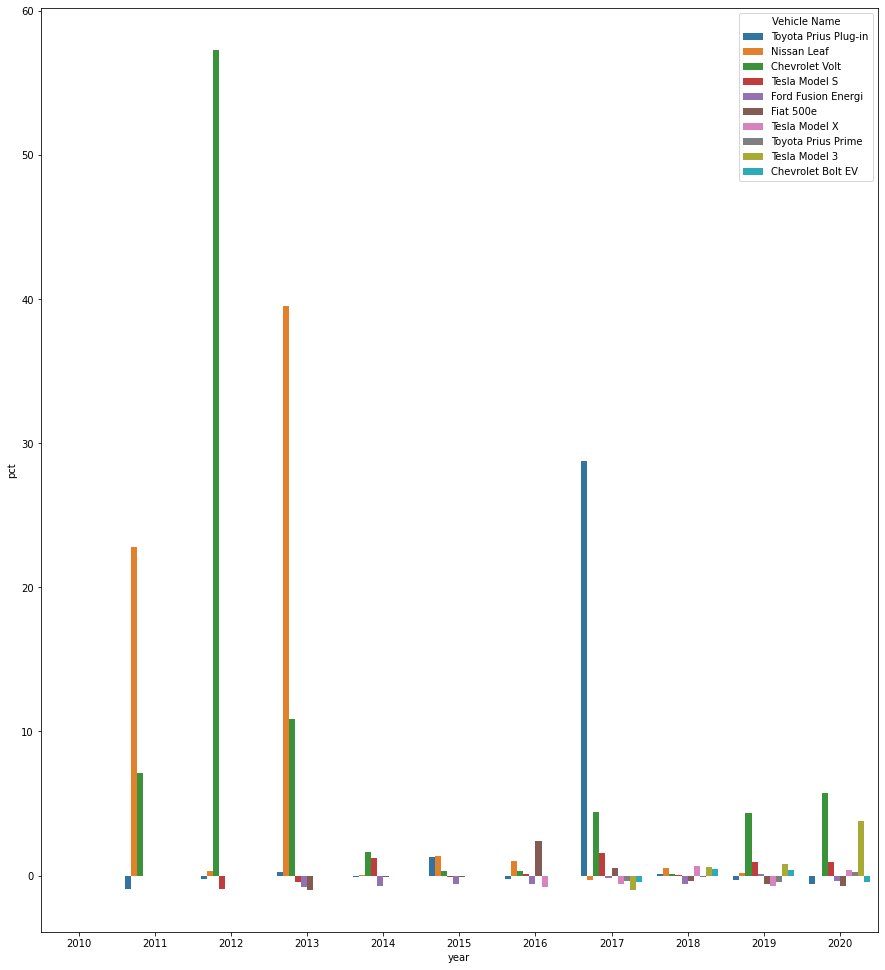

In [16]:
#Plot pct changes
bar_dim = (15, 17)
fig, ax = plt.subplots(figsize=bar_dim)
ev_plot = sns.barplot(x='year', y='pct', hue='Vehicle Name', data=ev_hi_reg)
plt.show()

In [17]:
#Select top 6 models in 2020 to make predictions on [Tesla Model 3, Tesla Model S, Chevrolet Volt, Ford Fusion Energi, Tesla Model X, Chevrolet Bolt EV]
ev_reg_pred = ev_hi_reg.loc[ev_hi_reg['Vehicle Name'].isin(['Tesla Mode 3', 'Tesla Model S', 'Chevrolet Volt', 
                                                            'Ford Fusion Energi', 'Tesla Model X', 'Chevrolet Bolt EV'])]
print(ev_reg_pred)

           Vehicle Name  year  count        pct
79       Chevrolet Volt  2011   1320   7.148148
342       Tesla Model S  2012     98  -0.925758
80       Chevrolet Volt  2012   5712  57.285714
128  Ford Fusion Energi  2013   1242  -0.789456
81       Chevrolet Volt  2013  14775  10.896135
343       Tesla Model S  2013   7291  -0.432386
82       Chevrolet Volt  2014  23618   1.603395
129  Ford Fusion Energi  2014   6661  -0.691948
344       Tesla Model S  2014  13114   1.234833
130  Ford Fusion Energi  2015  11415  -0.597369
345       Tesla Model S  2015  22936  -0.115431
83       Chevrolet Volt  2015  30807   0.343172
346       Tesla Model S  2016  34343   0.114779
351       Tesla Model X  2016   4680  -0.821238
84       Chevrolet Volt  2016  41847   0.320345
131  Ford Fusion Energi  2016  16987  -0.594069
85       Chevrolet Volt  2017  54641   4.397708
132  Ford Fusion Energi  2017  22221  -0.148098
67    Chevrolet Bolt EV  2017  12545  -0.435444
347       Tesla Model S  2017  47580   1

In [18]:
#Turn 'Vehicle Name' column into categorical variable using OneHot Encoder
labelencoder = LabelEncoder()
ev_reg_pred['Vehicle Name'] = labelencoder.fit_transform(ev_reg_pred['Vehicle Name'])
print(ev_reg_pred)

     Vehicle Name  year  count        pct
79              1  2011   1320   7.148148
342             3  2012     98  -0.925758
80              1  2012   5712  57.285714
128             2  2013   1242  -0.789456
81              1  2013  14775  10.896135
343             3  2013   7291  -0.432386
82              1  2014  23618   1.603395
129             2  2014   6661  -0.691948
344             3  2014  13114   1.234833
130             2  2015  11415  -0.597369
345             3  2015  22936  -0.115431
83              1  2015  30807   0.343172
346             3  2016  34343   0.114779
351             4  2016   4680  -0.821238
84              1  2016  41847   0.320345
131             2  2016  16987  -0.594069
85              1  2017  54641   4.397708
132             2  2017  22221  -0.148098
67              0  2017  12545  -0.435444
347             3  2017  47580   1.537871
352             4  2017  12737  -0.612303
353             4  2018  20993   0.648190
348             3  2018  55816   0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Set feature (X) and target (y) variable
X = ev_reg_pred.loc[:, 'Vehicle Name':'year']
y = ev_reg_pred['count']

In [20]:
#Split data into 70:30 for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [21]:
#Fit linear regression model to training set
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
#Predict model
y_pred = lr.predict(X_test)
y_pred

array([46328.21568379, 22778.37186248, 41452.31020232, 39429.1992546 ,
       30688.94376553, 43293.54926221, 32530.18282541, 23789.92733634,
       14038.11637341, 29677.38829167, 19925.57732874, 45316.66020993,
        1433.51087673, 11185.32183966, 40440.75472846])

In [23]:
#Get accuracy of model
pred_score = lr.score(X_test, y_test)
pred_score

0.5316674414776563

In [24]:
#Insert into new column based on stacked predictions
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
ev_reg_pred['count_pred'] = np.hstack([y_pred_train, y_pred_test])
print(ev_reg_pred)

     Vehicle Name  year  count        pct    count_pred
79              1  2011   1320   7.148148  24801.482810
342             3  2012     98  -0.925758  28665.832818
80              1  2012   5712  57.285714   9162.210892
128             2  2013   1242  -0.789456  20937.132803
81              1  2013  14775  10.896135   4286.305410
343             3  2013   7291  -0.432386  34553.293773
82              1  2014  23618   1.603395   6309.416358
129             2  2014   6661  -0.691948  44305.104736
344             3  2014  13114   1.234833  10173.766366
130             2  2015  11415  -0.597369  42281.993788
345             3  2015  22936  -0.115431  35564.849247
83              1  2015  30807   0.343172  38417.643781
346             3  2016  34343   0.114779  18914.021855
351             4  2016   4680  -0.821238  33541.738299
84              1  2016  41847   0.320345  31700.499239
131             2  2016  16987  -0.594069  36576.404721
85              1  2017  54641   4.397708  16061

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
#Filter 'year' column by 2020 to see difference in predicted model
ev_reg_pred_diff = ev_reg_pred.loc[ev_reg_pred['year'].isin(['2020'])]
print(ev_reg_pred_diff)

     Vehicle Name  year  count       pct    count_pred
350             3  2020  60869  0.926234  19925.577329
355             4  2020  33528  0.423030  45316.660210
135             2  2020  25848 -0.365927   1433.510877
88              1  2020  53743  5.703630  11185.321840
70              0  2020  30601 -0.430605  40440.754728


In [26]:
#Create 'year' column with 2021
next_year = ['2021', '2021', '2021', '2021', '2021']
ev_reg_pred_diff['pred_year'] = next_year
print(ev_reg_pred_diff)

     Vehicle Name  year  count       pct    count_pred pred_year
350             3  2020  60869  0.926234  19925.577329      2021
355             4  2020  33528  0.423030  45316.660210      2021
135             2  2020  25848 -0.365927   1433.510877      2021
88              1  2020  53743  5.703630  11185.321840      2021
70              0  2020  30601 -0.430605  40440.754728      2021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


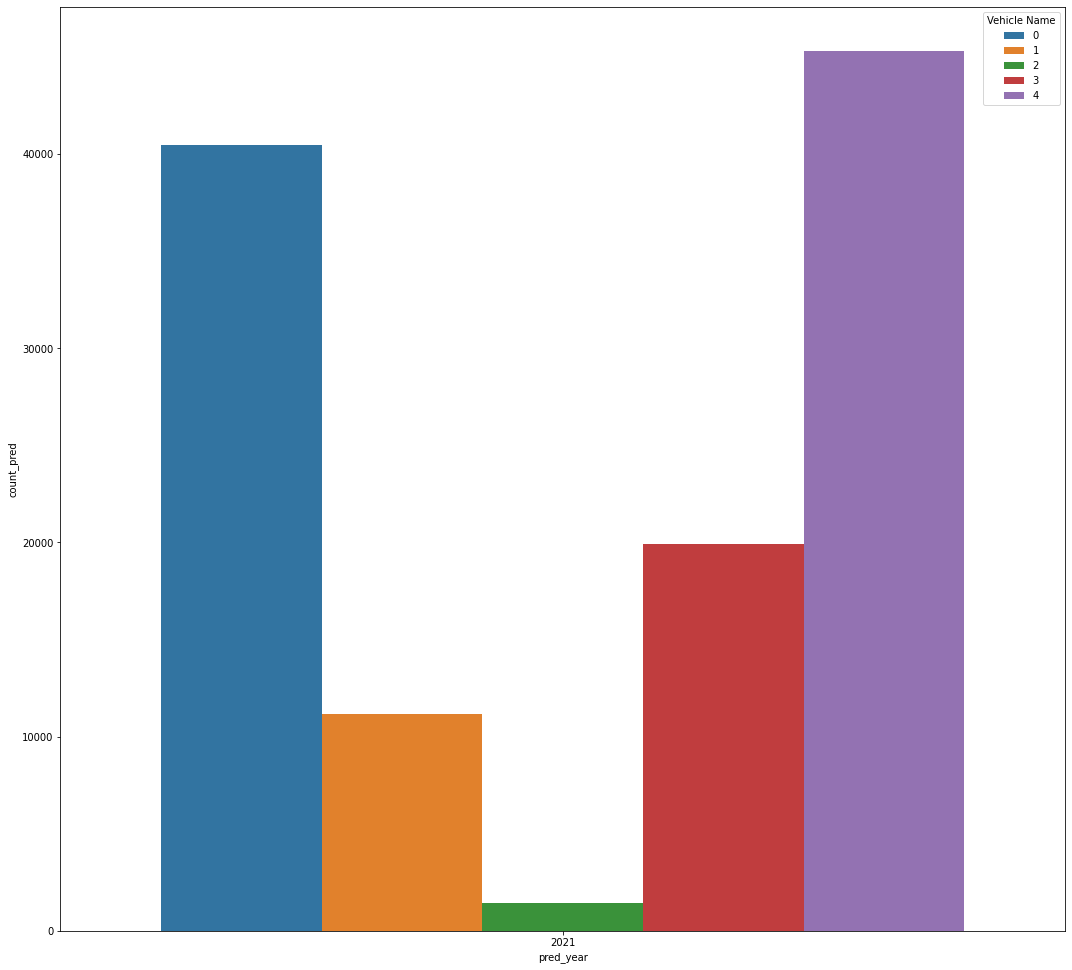

In [27]:
#Plot predictions
bar_dim = (18, 17)
fig, ax = plt.subplots(figsize=bar_dim)
ev_pred_graph = sns.barplot(x='pred_year', y='count_pred', hue='Vehicle Name', data=ev_reg_pred_diff)
plt.show()

In [28]:
#Based on our Linear Regression Model, it predicted Tesla Model X to the highest register count followed by Chevrolet Bolt EV with Ford Fusion Energi having least register count. 